In [1]:
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torchvision import transforms, datasets
import time

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from functions_VI import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
import pickle

In [3]:
# EncoderCNN architecture
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 768
CNN_embed_dim = 512   # latent dim extracted by 2D CNN
res_size = 224        # ResNet image size
dropout_p = 0.0       # dropout probability

In [4]:
# DecoderRNN architecture
RNN_hidden_layers = 3
RNN_hidden_nodes = 512
RNN_FC_dim = 256

# training parameters
k = 2             # number of target category
epochs = 3       # training epochs
batch_size = 144   #这要设置成和训练数据集一样的常度
learning_rate = 1e-3
log_interval = 10   # interval for displaying training info

# Select which frame to begin & end in videos
begin_frame, end_frame, skip_frame = 1, 18, 1

In [5]:
import torch
from torch import nn
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
def normalize_list(lst):
    np_list = np.array(lst)
    normalized_list = (np_list - np_list.min()) / (np_list.max() - np_list.min()) + 1
    return normalized_list.tolist()
def L1_tensor(x_feature):
    for i in range(0, len(x_feature)):
        #print(x_feature[i].shape)
        list_1 = []
        ls = x_feature[i]
        for j in ls:
            cc = np.sum(j)
            cc = abs(cc)
            list_1.append(cc)
            # print(cc)
        list_2 = normalize_list(list_1)
        # print(list_2)
        for k in range(0, len(x_feature[i])):
            x_feature[i][k] = x_feature[i][k] * list_2[k]
    return  x_feature
if torch.cuda.is_available():
    transformer_encoder = transformer_encoder.to('cuda')
def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    cnn_encoder, rnn_decoder = model
    cnn_encoder.train()
    rnn_decoder.train()

    losses = []
    scores = []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device).view(-1, )

        N_count += X.size(0)

        optimizer.zero_grad()       
        src,aa = cnn_encoder(X)
        out = transformer_encoder(src)
        x_f = out.cpu().data.numpy()
        x_f = L1_tensor(x_f)
        x_f = torch.FloatTensor(x_f)
        out_1 = x_f.to('cuda')
        #print(out_1.shape)
        #output,hidden = rnn_decoder(cnn_encoder(X))   # output has dim = (batch, number of classes)
        output,hidden = rnn_decoder(out_1)   # output has dim = (batch, number of classes)
        loss = F.cross_entropy(output, y)
        losses.append(loss.item())

        # to compute accuracy
        y_pred = torch.max(output, 1)[1]  # y_pred != output
        step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
        scores.append(step_score)         # computed on CPU

        loss.backward()
        optimizer.step()

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item(), 100 * step_score))

    return losses, scores,hidden,aa


def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    cnn_encoder, rnn_decoder = model
    cnn_encoder.eval()
    rnn_decoder.eval()

    test_loss = 0
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for X, y in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device).view(-1, )
            src,aa = cnn_encoder(X)
            out = transformer_encoder(src)
            x_f = out.cpu().data.numpy()
            x_f = L1_tensor(x_f)
            x_f = torch.FloatTensor(x_f)
            out_1 = x_f.to('cuda')
            #print(out.shape)
            #output,hidden = rnn_decoder(cnn_encoder(X))   # output has dim = (batch, number of classes)
            output,hidden = rnn_decoder(out_1)   # output has dim = (batch, number of classes)

            #output,hidden = rnn_decoder(cnn_encoder(X))

            loss = F.cross_entropy(output, y, reduction='sum')
            test_loss += loss.item()                 # sum up batch loss
            y_pred = output.max(1, keepdim=True)[1]  # (y_pred != output) get the index of the max log-probability

            # collect all y and y_pred in all batches
            all_y.extend(y)
            all_y_pred.extend(y_pred)

    test_loss /= len(test_loader.dataset)

    # compute accuracy
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    print(all_y_pred)
    test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())

    # show information
    print('\nTest set ({:d} samples): Accuracy: {:.2f}%\n'.format(len(all_y), 100* test_score))


    y_tru = all_y.cpu().data.squeeze().numpy()
    y_pre = all_y_pred.cpu().data.squeeze().numpy()
    return test_loss, test_score,hidden,y_tru,y_pre

In [6]:
# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# Data loading parameters
params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True} if use_cuda else {'batch_size': batch_size}


In [7]:
# Create model
cnn_encoder = ResCNNEncoder(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)
rnn_decoder = DecoderRNN(CNN_embed_dim=CNN_embed_dim, h_RNN_layers=RNN_hidden_layers, h_RNN=RNN_hidden_nodes, 
                         h_FC_dim=RNN_FC_dim, drop_p=dropout_p, num_classes=k).to(device)
if torch.cuda.device_count() >= 1:
    print("Using", torch.cuda.device_count(), "GPU!")
    # Combine all EncoderCNN + DecoderRNN parameters
    crnn_params = list(cnn_encoder.fc1.parameters()) + list(cnn_encoder.bn1.parameters()) + \
                  list(cnn_encoder.fc2.parameters()) + list(cnn_encoder.bn2.parameters()) + \
                  list(cnn_encoder.fc3.parameters()) + list(rnn_decoder.parameters())
elif torch.cuda.device_count() == 0:
    print("Using", torch.cuda.device_count(), "CPU!")
    # Combine all EncoderCNN + DecoderRNN parameters
    crnn_params = list(cnn_encoder.fc1.parameters()) + list(cnn_encoder.bn1.parameters()) + \
                  list(cnn_encoder.fc2.parameters()) + list(cnn_encoder.bn2.parameters()) + \
                  list(cnn_encoder.fc3.parameters()) + list(rnn_decoder.parameters())
optimizer = torch.optim.Adam(crnn_params, lr=learning_rate)
# record training process
epoch_train_losses = []
epoch_train_scores = []
epoch_test_losses = []
epoch_test_scores = []

Using 2 GPU!


In [8]:
# start training
#torch.backends.cudnn.enabled = False
state_dict = torch.load('./model/optimizer_epoch.pth')
optimizer.load_state_dict(state_dict)
state_dict=torch.load('./model/cnn_encoder_epoch.pth')
cnn_encoder.load_state_dict(state_dict)
state_dict_R=torch.load('./model/LSTM_decoder_epoch.pth')
rnn_decoder.load_state_dict(state_dict_R)
state_dict_t=torch.load('./model/transformer_encoder.pth')
transformer_encoder.load_state_dict(state_dict_t)
feature_extractor=torch.load('feature_extractor.pth')

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models.feature_extraction import create_feature_extractor
import einops
import matplotlib.pyplot as plt
 
def read_image_as_tensor(name: str):
    preprocess = transforms.Compose([
        transforms.ToTensor(),  # 将图像转换为张量
        transforms.Resize((224, 224), antialias=True)
    ])
 
    return preprocess(Image.open(name)).unsqueeze(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

x = read_image_as_tensor('./feature/17.jpg')
out = feature_extractor(x.to(device))

True


In [10]:
print(out['4.0.conv1'].shape)
print(out['4.1.conv1'].shape)
f1 = out['4.0.conv1'] # feature map

torch.Size([1, 64, 56, 56])
torch.Size([1, 64, 56, 56])


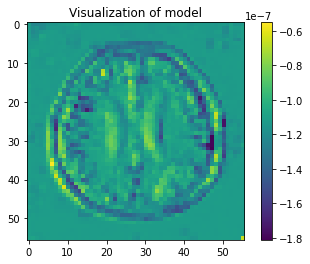

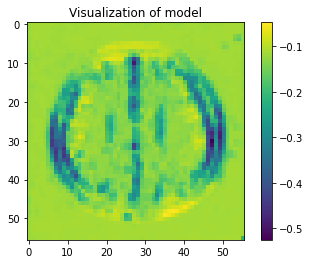

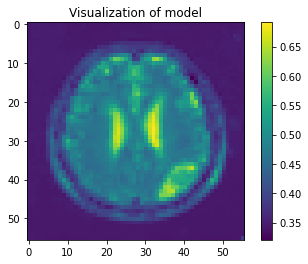

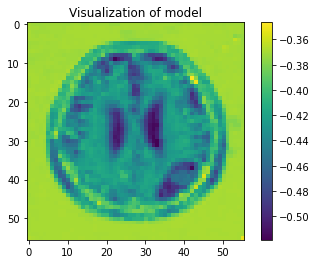

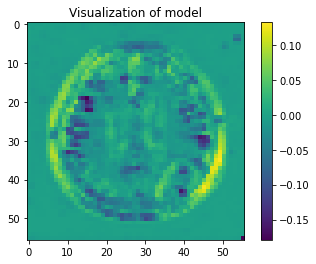

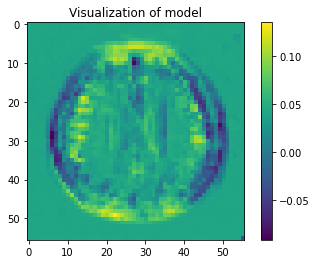

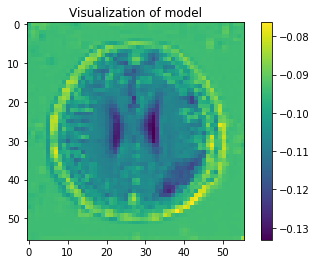

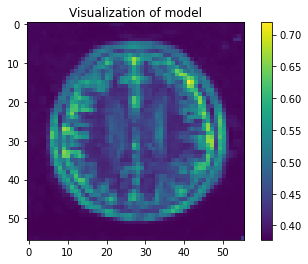

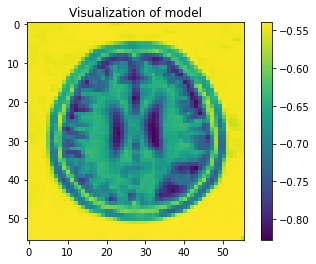

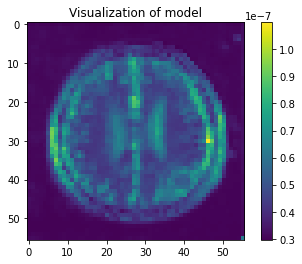

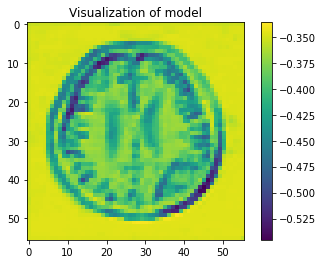

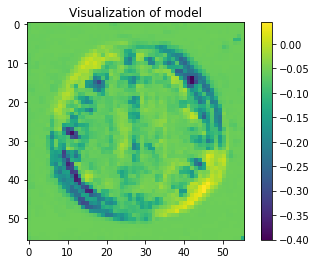

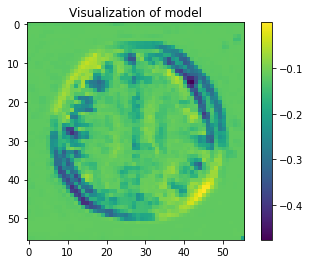

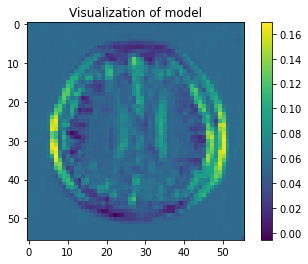

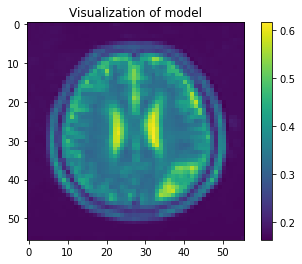

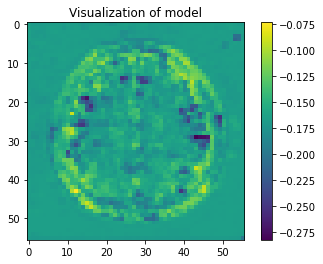

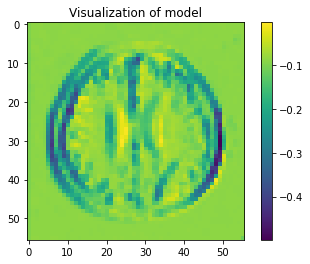

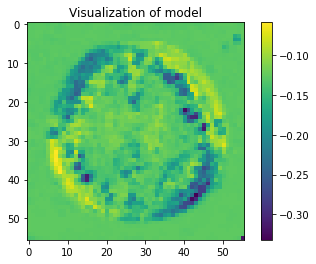

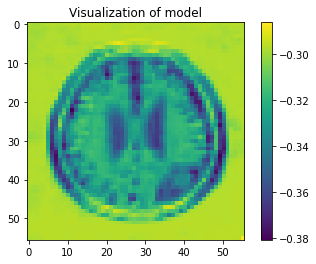

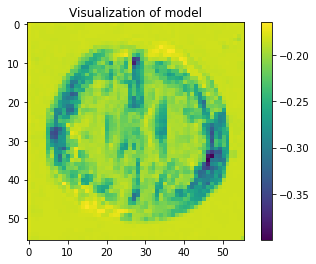

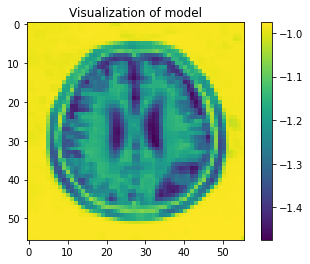

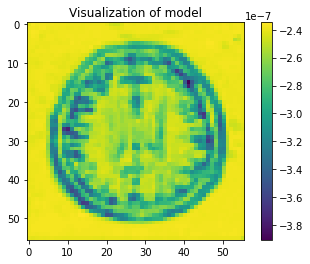

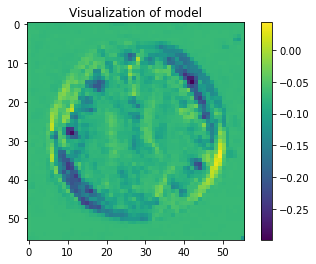

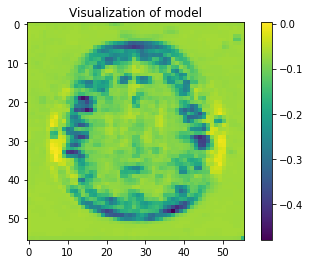

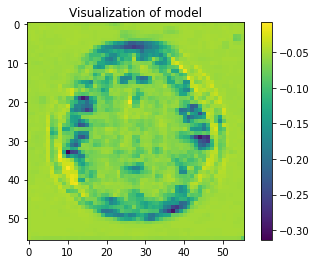

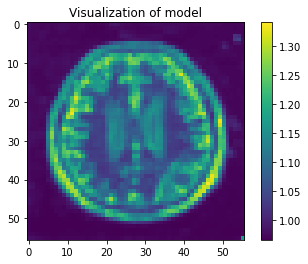

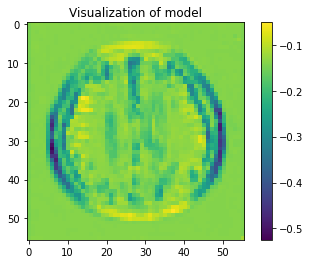

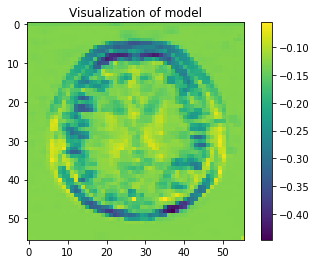

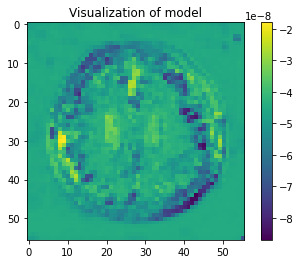

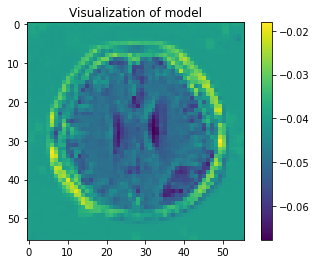

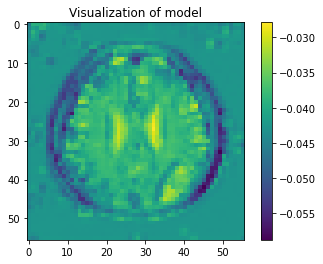

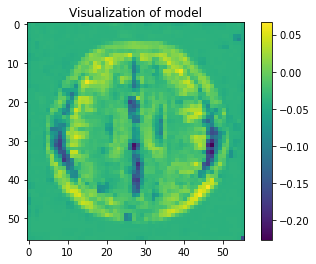

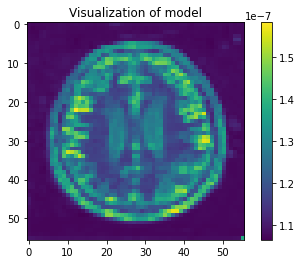

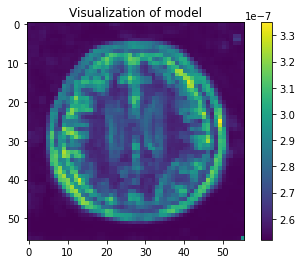

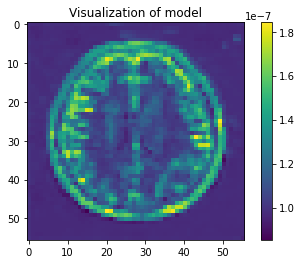

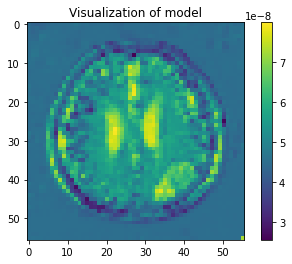

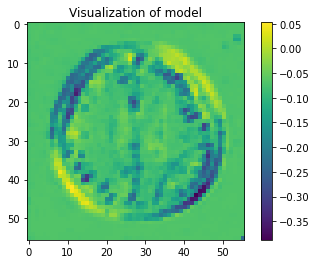

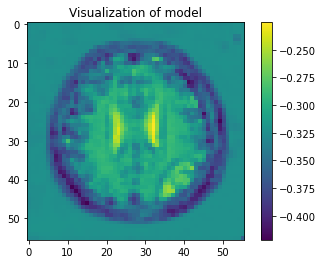

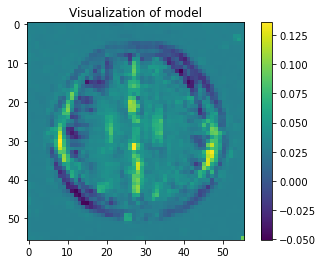

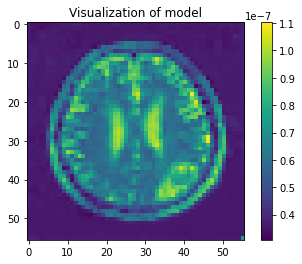

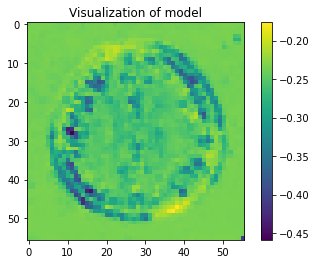

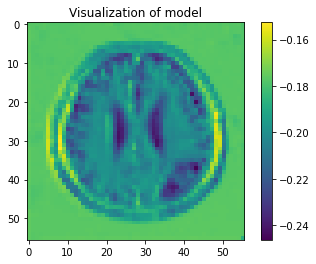

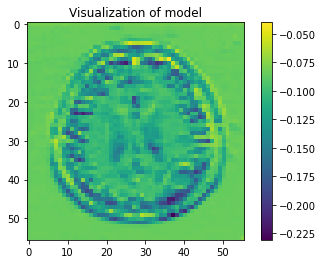

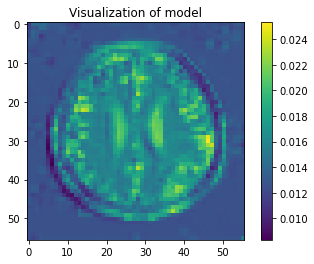

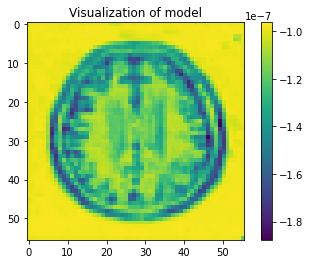

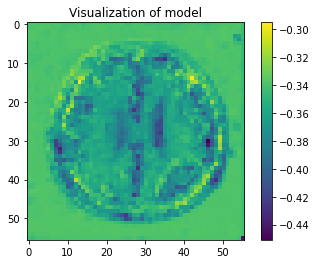

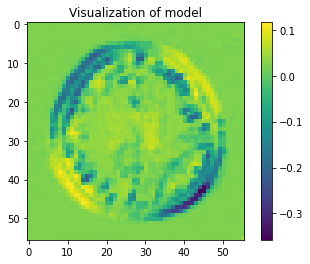

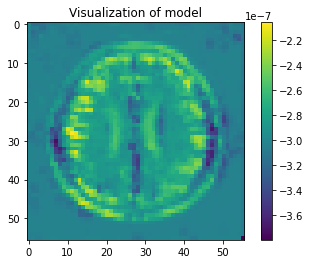

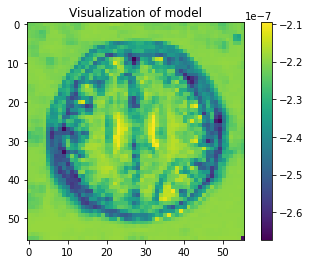

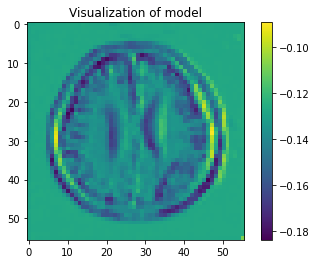

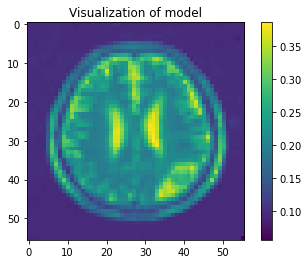

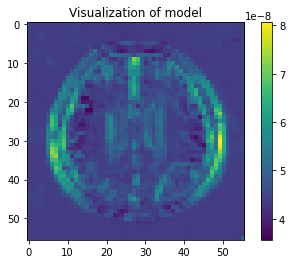

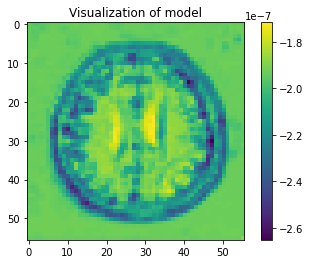

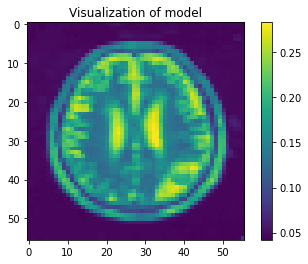

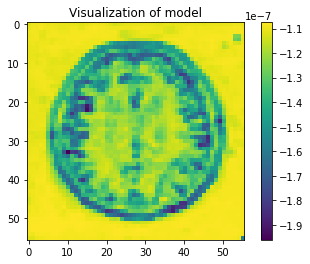

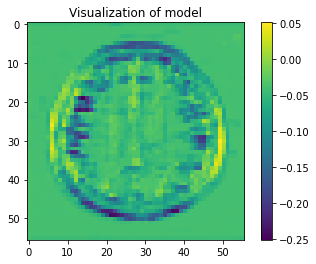

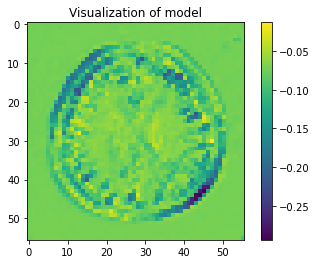

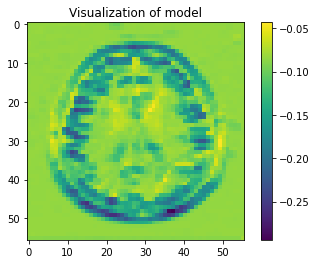

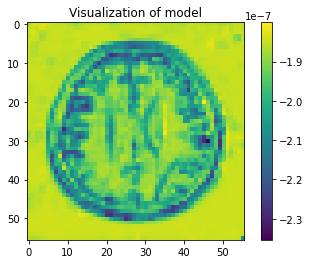

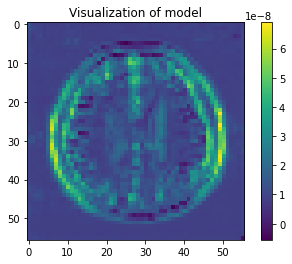

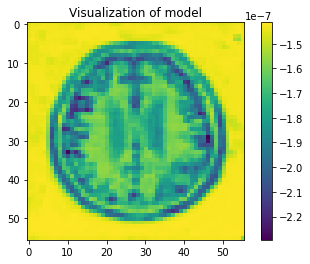

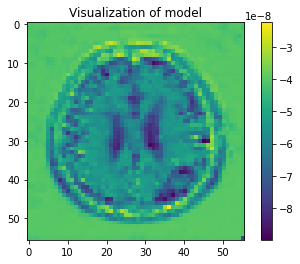

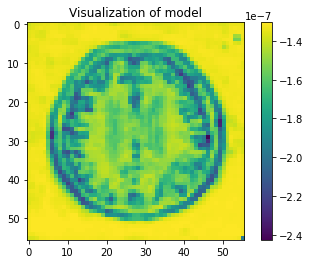

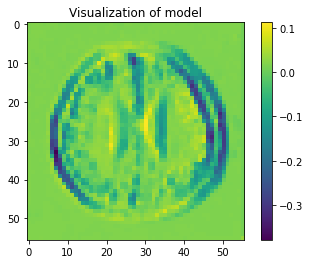

In [11]:
import matplotlib.pyplot as plt
for j in range(0,f1.shape[1]):
    # Visualize the specified slice of the loaded tensor
    plt.imshow(f1[0][j].cpu().detach().numpy(), cmap='viridis')
    plt.colorbar()
    plt.title("Visualization of model")
    plt.show()

In [12]:
save_model_path = "./ResNetCRNN_ckpt/"
data_path = "./" 
test_list = ["example_1","example_2"]
test_label = [0, 0]

In [13]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from functions import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
import pickle
transform = transforms.Compose([transforms.Resize([res_size, res_size]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

selected_frames = np.arange(begin_frame, end_frame, skip_frame).tolist()
valid_set = Dataset_CRNN(data_path, test_list, test_label, selected_frames, transform=transform)

valid_loader = data.DataLoader(valid_set, **params)

In [14]:
epoch_test_loss, epoch_test_score,thidden,y_tru,y_pre = validation([cnn_encoder, rnn_decoder], device, optimizer, valid_loader)

tensor([[0],
        [0]], device='cuda:0')

Test set (2 samples): Accuracy: 100.00%

